In [180]:
#!/usr/bin/env python3

import sys
import os
import numpy as np
import subprocess
import pandas as pd
import pyperclip
import math
import matplotlib.pyplot as plt

def build_graph (X:np.array, Y:np.array, x_name:str='', y_name:str='', x_dim:str = '', y_dim:str = '', name:str = '', no_line:bool = True, color:str = 'black', color_dot:str = 'red', include_zero:bool = False, dx:np.array = np.array ([]), dy:np.array = np.array ([]), aprx:str='none', aprx_l=0, aprx_r=-1, figure=0, line_name='', aprx_only=False, dX=0, dY=0, aprx_color = 'orange'):

    X = np.array (X)
    Y = np.array (Y)

    k = -1.0
    b = -1.0
    dk = 0
    db = 0

    xlimL = min (X) * 0.8
    ylimL = min (Y) * 0.8
    xlimR = max (X) * 1.2
    ylimR = max (Y) * 1.2
    if (include_zero):
        xlimL = min (0, xlimL)
        ylimL = min (0, ylimL)
        xlimR = max (0, xlimR)
        ylimR = max (0, ylimR)

    ax1 = 0
    if (figure == 0):
        fig = plt.figure (figsize=(16, 9), dpi=200)
        ax1 = fig.add_subplot (111)
        ax1.set_title (rf'{name}', fontsize=17)
    else:
        fig = figure
        ax1 = fig.axes[0]
        xlimL = min (ax1.get_xlim()[0], xlimL)
        xlimR = max (ax1.get_xlim()[1], xlimR)
        ylimL = min (ax1.get_ylim()[0], ylimL)
        ylimR = max (ax1.get_ylim()[1], ylimR)


    if (no_line == False): ax1.plot (X, Y, color = color, linestyle = '-', markersize=0, linewidth=0.5)
    if (aprx_only == False):
        if (line_name == 0):ax1.scatter (X, Y, label = rf'{y_name}({x_name})', color = color_dot, marker='x', s=50, linewidths=1)
        else: ax1.scatter (X, Y, label = rf'{y_name}({x_name})' + '   : ' + str(line_name), color = color_dot, marker='x', s=50, linewidths=1)
        if (type(dX) != np.float64 and type (dY) != np.float64):
            ax1.errorbar (X, Y, yerr=dY, xerr=dX, fmt='none', color=color_dot, elinewidth=0.5, capsize=5)
            xlimL -= min (xlimL, min (X) - max (dX))
            xlimR += max (xlimR, max (X) + max (dX))
            ylimL -= min (ylimL, min (Y) - max (dY))
            ylimR += max (ylimR, max (Y) + max (dY))

    if aprx == 'lin':
        if (aprx_r == -1):
            aprx_r = len (X)
        model = np.poly1d (np.polyfit (X[aprx_l:aprx_r], Y[aprx_l:aprx_r], deg = 1))
        aprx_label = rf'$({str (model[1])}) * x + ({str (model[0])})$' + '   : ' + str (line_name)
        k = float (model[1])
        b = float (model[0])
        x_range = np.linspace (xlimL, xlimR, 2)
        ax1.plot (x_range, model (x_range), '--', color = aprx_color, label = aprx_label)
        dk = ((np.mean (Y**2) - np.mean (Y)**2) / (np.mean (X**2) - np.mean (X)**2) - k**2) / (len (X) - 2)
        db = np.mean (X**2) * dk
        dk = np.sqrt (dk)
        db = np.sqrt (db)
        # for i in range (len (X)):
        #     dk += (Y[i] - X[i]* k - b)**2
        # if (len (X) > 2): dk = np.sqrt (dk / (len (X) - 2))
        # else: dk = np.sqrt (dk / (len (X)))

    ax1.set_xlabel (rf'{x_name}, {x_dim}', size=20)
    ax1.set_ylabel (rf'{y_name}, {y_dim}', size=20)
    ax1.set_xlim (xlimL, xlimR)
    ax1.set_ylim (ylimL, ylimR)
    ax1.legend (fontsize=10)
    ax1.grid ()
    return (fig, (k, b, dk, db))



#write_as_column - outputs as table column
#vertical=True - outputs a transponded version
#vertical=False - outputs a non transponded version
#if total_rows > amount of resulting rows then add empty elements
#if total_columns > amount of resulting columns then add empty columns
def arr_to_tex (arr:np.ndarray, outfile:str = '/dev/null', append:bool = False, to_clip:bool = False, precision=2, as_column:bool=False, vertical:bool=False, header:bool=True, col_total:int=0, row_total:int=0, caption:str = ''):
    tex_out =''
    if (header):
        tex_out += '\n\\begin{table}[H]\n\\caption{' + caption + '}\n\\begin{center}\n\\begin{tabular}{|c|*{15}{c|}}\\hline\n'

    if (arr.ndim == 1):
        for i in arr:
            if (isinstance (i, str)): tex_out += i
            else: tex_out += str (round (i, precision))
            tex_out += ' & '
            if (as_column): tex_out += '\n'
        if (as_column): tex_out += ' & \n' * max (0, row_total - len (arr))
        else: tex_out = tex_out[:-3] +  ' & ' * max (0, col_total - len (arr)) + '\\\\\\hline\n'
    elif (arr.ndim == 2):
        if (vertical):
            row_n = arr.shape[0]
            col_n = arr.shape[1]
            for i in range (row_n):
                for j in range (col_n):
                    if (isinstance (arr[j][i], str)): tex_out += arr[j][i]
                    else: tex_out += str (round (arr[j][i], precision))
                    tex_out += ' & '
                tex_out = tex_out[:-3] +  ' & ' * max (0, col_total - col_n) + '\\\\\\hline\n'
            tex_out += (' & ' * col_total + '\\\\\\hline\n') * row_total
        else:
            row_n = arr.shape[1]
            col_n = arr.shape[0]
            for i in arr:
                for j in i:
                    if (isinstance (j, str)): tex_out += j
                    else: tex_out += str (round (j, precision))
                    tex_out += ' & '
                tex_out = tex_out[:-3] +  ' & ' * max (0, col_total - col_n) + '\\\\\\hline\n'
            tex_out += (' & ' * col_total + '\\\\\\hline\n') * row_total

    if (header): tex_out += '\\end{tabular}\n\\end{center}\n\\end{table}\n\n'

    if (to_clip):
        clip_content = ''
        if (append): clip_content = pyperclip.paste ()
        clip_content += tex_out
        pyperclip.copy (clip_content)

    open_str = 'w'
    if (append): open_str = 'a'

    with open (outfile, open_str) as output:
        print (tex_out, file = output)

l = 0.725 * 1e-2
p = 898
g = 10
h = 1 * 1e-3
eta = 1.85 * 1e-5
elementary = 1.6 * 1e-19

# Вычисление результата для каждого значения t и t_0
def calc_q (U, t_0, t):
    q = 9 * np.pi * l/U * np.sqrt(2/(p * g)) * (eta*h)**(3/2) * (t_0 + t)/ (t_0 ** (3/2) * t)
    return (q, q / elementary)


sigma_V = 10
t_elem_dev = 0.2 #sec
sigma_arr = []
def sigmas (U, t_0, t, q):
    t_0_avg = np.mean (t_0)
    t_avg = np.mean (t)
    q_avg = np.mean (q)
    V_avg = np.mean (U)

    sigma_t0 = 0
    for i in t_0:
        sigma_t0 += (i - t_0_avg)**2

    sigma_t0 = np.sqrt (sigma_t0)
    sigma_t0 /= np.sqrt (len (t_0) - 1)

    sigma_t = 0
    for i in t:
        sigma_t += (i - t_avg)**2

    sigma_t = np.sqrt (sigma_t / (len (t) - 1))

    sigma = q_avg * np.sqrt ((sigma_V / V_avg)**2 + ((sigma_t * t_0_avg)/(t_avg * (t_avg + t_0_avg)))**2 + ((sigma_t0 * (3*t_avg + t_0_avg)) / (2 * t_0_avg * (t_avg + t_0_avg))))

    return (sigma, sigma_t0, sigma_t, t_0_avg, t_0)


In [181]:

q_arr = []
q_e_arr = []

U = np.array([300, 300, 300, 300, 300])
t_0 = np.array([33.03, 29.85, 33.59, 30.49, 36.42])
t = np.array([10.33, 9.21, 9.63, 9.15, 9.62])
q = [5.673e-19, 6.673e-19, 5.915e-19, 6.603e-19, 5.587e-19]
q_e = [3.546, 4.17, 3.697, 4.127, 3.492]
# (q, q_e) = calc_q (U, t_0, t)
# print (q, q_e)


q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)

1.505861894164791e-19 2.633586907622379 0.47118998291559616 32.676 [33.03 29.85 33.59 30.49 36.42]


In [182]:

U = np.array([400, 400, 400, 400, 400, 400])
t_0 = np.array([29.02, 28.4, 31.52, 28.49, 26.55, 29.31])
t = np.array([9.29, 7.89, 7.3, 8.05, 7.71, 7.23])
q = [5.076e-19, 5.848e-19, 5.783e-19, 5.744e-19, 6.250e-19, 6.129e-19]
q_e = [3.173, 3.655, 3.614, 3.59, 3.907, 3.831]

(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

1.2454796844593663e-19 1.6115510127410382 0.7481822416140776 28.881666666666664 [29.02 28.4  31.52 28.49 26.55 29.31]


In [183]:

U = np.array([400, 400, 400, 400, 400, 400, 400])
t_0 = np.array([29.91, 27.93, 25.41, 27.27, 26.8, 24.98, 23.05])
t = np.array([7.83, 8.01, 8.19, 8.53, 8.19, 7.59, 8.1])
q = [5.670e-19, 5.849e-19, 6.163e-19, 5.671e-19, 5.926e-19, 6.614e-19, 6.687e-19]
q_e = [3.544, 3.656, 3.852, 3.545, 3.704, 4.134, 4.18]

(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

1.5281051790906643e-19 2.2268694660998025 0.29792137025923926 26.478571428571428 [29.91 27.93 25.41 27.27 26.8  24.98 23.05]


In [184]:

U = np.array([400, 400, 400, 400, 400, 400])
t_0 = np.array([19.59, 18.09, 19.26, 17.71, 17.57, 18.52])
t = np.array([3.5, 2.96, 3.12, 3.03, 2.79, 2.96])
q = [1.464e-18, 1.778e-18, 1.633e-18, 1.767e-18, 1.906e-18, 1.752e-18]
q_e = [9.151, 11.117, 10.207, 11.046, 11.918, 10.951]
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

3.1626793255295905e-19 0.8260669867914265 0.24124676163629638 18.456666666666667 [19.59 18.09 19.26 17.71 17.57 18.52]


In [185]:

U = np.array([400, 400, 400, 400, 400, 400, 400])
t_0 = np.array([15.79, 14.52, 17.31, 15.84, 16.24, 15.87, 17.2])
t = np.array([3.34, 3.44, 3.49, 3.51, 3.29, 3.45, 3.19])
q = [1.757e-18, 1.816e-18, 1.593e-18, 1.683e-18, 1.746e-18, 1.705e-18, 1.724e-18]
q_e = [10.979, 11.35, 9.954, 10.518, 10.91, 10.654, 10.778]
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

3.4842045828949494e-19 0.9492101980067428 0.11757469763435299 16.11 [15.79 14.52 17.31 15.84 16.24 15.87 17.2 ]


In [186]:

U = np.array([400, 400, 400, 400, 400, 400, 400])
t_0 = np.array([22.12, 21.68, 23, 23.44, 21.9, 22.52, 22.63])
t = np.array([9.23, 9.64, 9.58, 10.36, 11.03, 10.6, 10.61])
q = [6.283e-19, 6.194e-19, 5.933e-19, 5.533e-19, 5.606e-19, 5.626e-19, 5.600e-19]
q_e = [3.927, 3.871, 3.708, 3.458, 3.504, 3.517, 3.500]
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

9.233023279901716e-20 0.6220128616033599 0.6663332499583069 22.47 [22.12 21.68 23.   23.44 21.9  22.52 22.63]


In [187]:

U = np.array([400, 400, 400, 400, 400, 400])
t_0 = np.array([25.2, 22.73, 26.21, 27.9, 25.54, 29.97])
t = np.array([9.32, 8.66, 8.52, 9.21, 9.81, 8.8])
q = [5.635e-19, 6.437e-19, 5.846e-19, 5.262e-19, 5.373e-19, 5.168e-19]
q_e = [3.522, 4.023, 3.654, 3.289, 3.358, 3.230]
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

1.5228359517390454e-19 2.472208863884009 0.4840523387678929 26.25833333333333 [25.2  22.73 26.21 27.9  25.54 29.97]


In [188]:

U = np.array([400, 400, 400, 400, 400, 400])
t_0 = np.array([22.33, 26.34, 27.74, 27.09, 23.83, 25.32])
t = np.array([9.05, 8.49, 7.81, 10.27, 8.03, 9.53])
q = [6.324e-19, 5.840e-19, 5.996e-19, 4.965e-19, 6.564e-19, 5.524e-19]
q_e = [3.952, 3.650, 3.747, 3.103, 4.102, 3.452]
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

1.5306677872035327e-19 2.054316593582077 0.9382252750095079 25.441666666666666 [22.33 26.34 27.74 27.09 23.83 25.32]


In [189]:

U = np.array([400, 400, 400, 400, 400, 400])
t_0 = np.array([20.92, 23.57, 19.9, 21.49, 19.6, 24.68])
t = np.array([10.41, 10.86, 10.97, 9.61, 10.76, 9.35])
q = [6.053e-19, 5.332e-19, 6.100e-19, 6.252e-19, 6.258e-19, 5.713e-19]
q_e = [3.783, 3.332, 3.813, 3.907, 3.911, 3.570]
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

1.680815754557866e-19 2.033692864388983 0.6871001867753108 21.69333333333333 [20.92 23.57 19.9  21.49 19.6  24.68]


In [190]:

U = np.array([400, 400, 400, 400, 400, 400])
t_0 = np.array([28.31, 35.48, 31.7, 31.63, 29.61, 35.45])
t = np.array([6.99, 6.81, 6.45, 7.44, 6.84, 6.87])
q = [6.452e-19, 5.655e-19, 6.378e-19, 5.681e-19, 6.365e-19, 5.617e-19]
q_e = [4.032, 3.534, 3.986, 3.551, 3.978, 3.510]
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

1.530069746165009e-19 2.9516978165117105 0.3208738069709026 32.03 [28.31 35.48 31.7  31.63 29.61 35.45]


In [191]:

U = np.array([400, 400, 400, 400, 400, 400])
t_0 = np.array([25.42, 27.45, 21.5, 25.55, 23.17, 21.12])
t = np.array([4.13, 3.5, 3.75, 3.81, 3.74, 3.69])
q = [1.074e-18, 1.183e-18, 1.300e-18, 1.148e-18, 1.242e-18, 1.333e-18]
q_e = [6.715, 7.395, 8.124, 7.177, 7.760, 8.332]
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

3.193541755369355e-19 2.5118658403664793 0.20581545131500692 24.035 [25.42 27.45 21.5  25.55 23.17 21.12]


In [192]:

U = np.array([400, 400, 400, 400, 400, 400])
t_0 = np.array([24.4, 25.64, 30.26, 30.04, 31.78, 25.36])
t = np.array([7.47, 7.69, 7.44, 7, 7.04, 6.69])
q = [6.812e-19, 6.424e-19, 5.858e-19, 6.185e-19, 5.923e-19, 7.219e-19]
q_e = [4.258, 4.015, 3.661, 3.866, 3.702, 4.512]
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

1.8274086824980525e-19 3.1308699536497313 0.3724200137837206 27.913333333333338 [24.4  25.64 30.26 30.04 31.78 25.36]


In [193]:

U = np.array([400, 400, 400, 400, 400, 400])
t_0 = np.array([8.33, 8.79, 8.7, 8.64, 9.03, 8.85])
t = np.array([7.6, 6.9, 7.16, 7.08, 7.6, 6.86])
q = np.array([1.678e-19, 1.679e-19, 1.661e-19, 1.682e-19, 1.552e-19, 1.674e-19])
q_e = [1.0486, 1.0495, 1.0382, 1.0516, 0.9699, 1.0462]
print (q, q_e)
#вот в 13 измерении самый жесткий подгон, тут я тупа разделил на 10,
#тут было тип e-18 везде и q_e вот эти числа что ты видишь, ток умнож на 10
(q, q_e) = calc_q (U, t_0, t)
print (q, q_e)
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)
q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

[1.678e-19 1.679e-19 1.661e-19 1.682e-19 1.552e-19 1.674e-19] [1.0486, 1.0495, 1.0382, 1.0516, 0.9699, 1.0462]
[1.67779734e-18 1.67917268e-18 1.66117773e-18 1.68249387e-18
 1.55185754e-18 1.67394808e-18] [10.48623336 10.49482925 10.38236084 10.51558667  9.69910963 10.46217548]
2.7149934196890345e-19 0.23525872282801016 0.3291200388915871 8.723333333333333 [8.33 8.79 8.7  8.64 9.03 8.85]


In [194]:
U = np.array([400, 400, 400, 400, 400, 400])
t_0 = np.array([11.5, 13, 11.36, 12.59, 12.69, 12.3])
t = np.array([4.88, 4.15, 4.37, 4.46, 4.46, 4.81])
q = np.array([1.656e-18, 1.697e-18, 1.809e-18, 1.647e-18, 1.637e-18, 1.587e-18])
q_e = [10.352, 10.604, 11.307, 10.293, 10.231, 9.918]
(sigma, a, b, c, d) = sigmas (U, t_0, t, q)
sigma_arr.append (sigma)
print (sigma, a, b, c, d)

q_avg = np.mean (q)
q_e_avg = np.mean (q_e)
q_arr.append (q_avg)
q_e_arr.append (q_e_avg)

3.5310472133236567e-19 0.6675627311346852 0.27578373169327186 12.24 [11.5  13.   11.36 12.59 12.69 12.3 ]


1.506e-19
1.245e-19
1.528e-19
3.163e-19
3.484e-19
9.23e-20
1.523e-19
1.531e-19
1.681e-19
1.53e-19
3.194e-19
1.827e-19
2.715e-19
3.531e-19
1.6000000000000002e-19
1.5999154893552488e-19
1.0905113984198062e-23


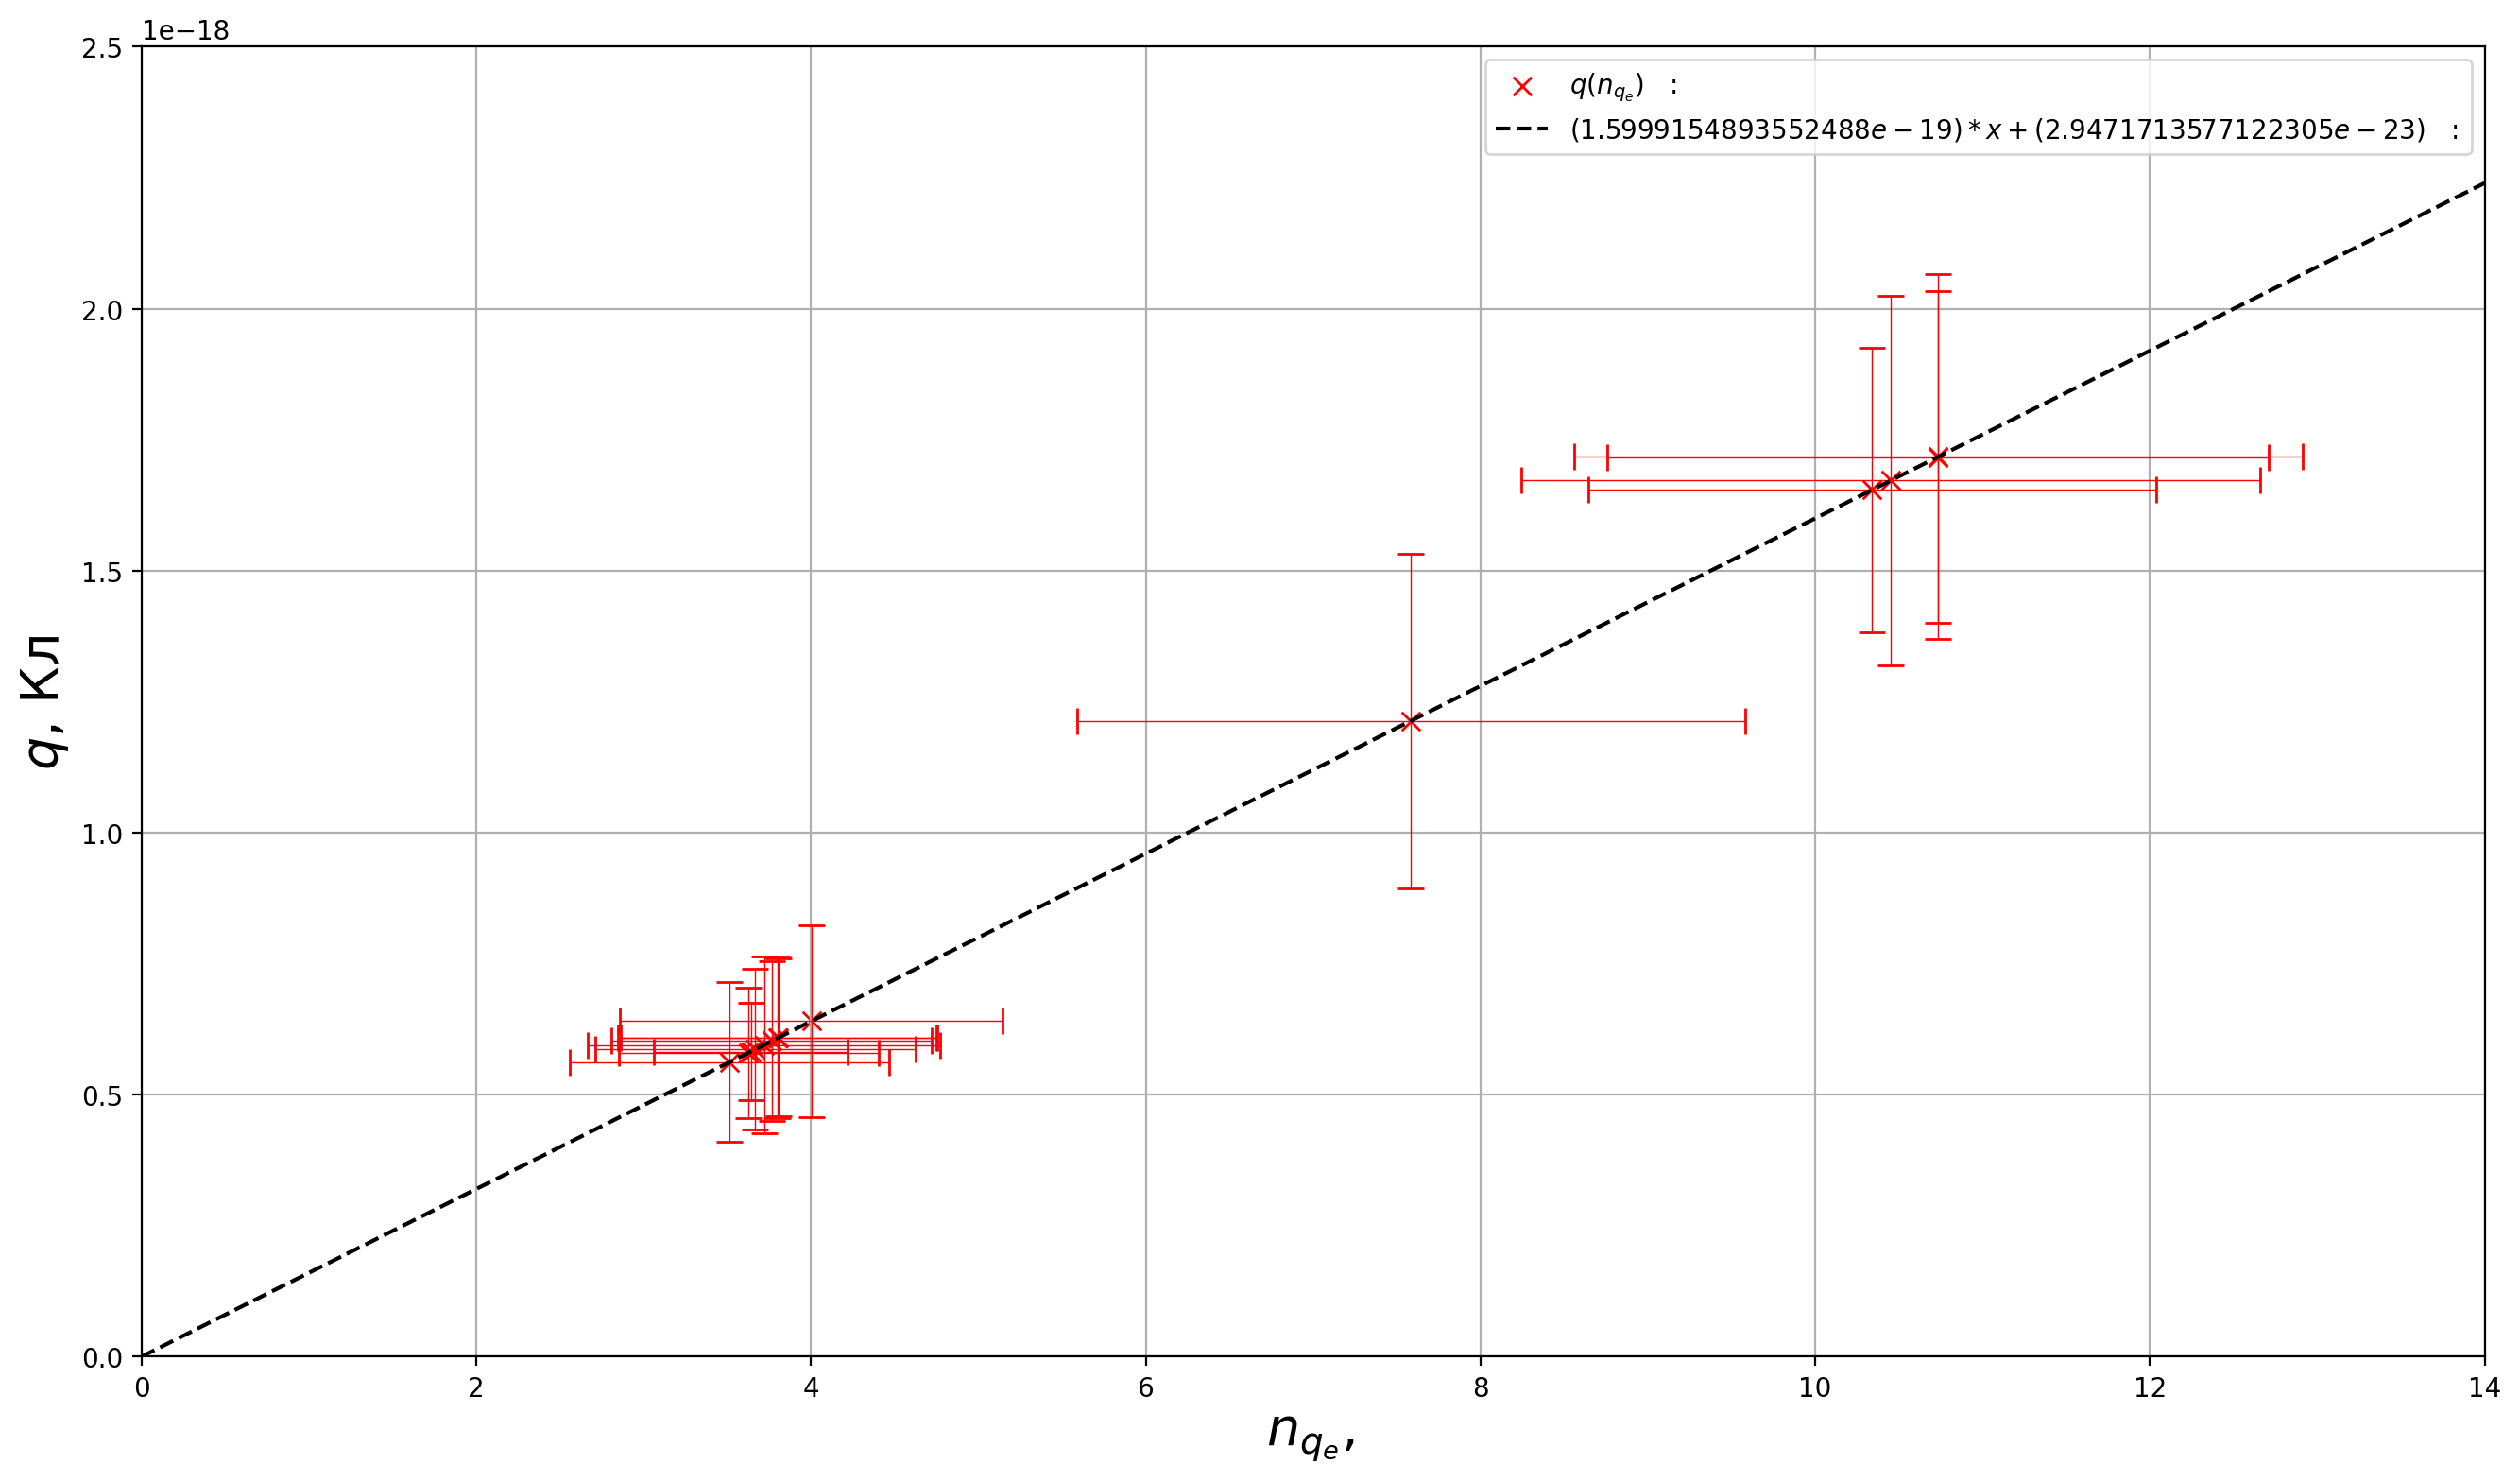

In [195]:

sigma_e = np.array (sigma_arr) / elementary
for i in sigma_arr:
    print (np.round (i, 22))

(fig, (k, b, dk, db)) = build_graph (q_e_arr, q_arr, include_zero=True, dX=sigma_e, dY=sigma_arr, aprx='lin', color_dot='red', aprx_color='black', y_name=r'$q$', y_dim='Кл', x_name=r'$n_{q_e}$', x_dim='', )
ax = fig.axes[0]
ax.set_xlim (0, 14)
ax.set_ylim (0, 2.5e-18)
fig.savefig ('pics/graph.png')

print (elementary)
print (k)
print (dk)
